In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import yaml
import json

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_colwidth', 999)

In [3]:
def load_yaml(path):
    with open(path, 'r') as f:
        return yaml.safe_load(f)
def load_json(path):
    with open(path, 'r') as f:
        return json.load(f)

In [4]:
model_path = '../models/'

In [5]:
config_list = []
metric_list = []

for f in os.listdir(model_path):
    subdir = model_path + f + '/'
    print(subdir)
    config_path = subdir + 'config.yaml'
        
    
    metrics_path = subdir + 'metrics.json'
    if not (os.path.exists(config_path) and os.path.exists(metrics_path)):
        continue
    config_list.append(load_yaml(config_path))
    metric_list.append(load_json(metrics_path))

../models/baseline_more_data/
../models/larger_2_200_epochs/
../models/larger_3_longer/
../models/larger_3_longer_lower_lr/
../models/larger_longer/
../models/larger_model/
../models/learned_embeddings/
../models/no_learned_embeddings/
../models/pad_shared/
../models/pad_shared_gradnorm_10_layer/
../models/pad_shared_grad_norm/
../models/pad_unshared/
../models/zeros_shared/
../models/zeros_unshared/


In [6]:
len(config_list), len(metric_list)

(13, 13)

In [7]:
def expand_config_item(config_item):
    expanded = {}
    expanded['input_padding'] = config_item['data']['input_padding']
    expanded['train_batch_size'] = config_item['loader']['train']['batch_size']
    expanded['n_beams'] = config_item['metrics']['n_beams']
    for k, v in config_item['model_args'].items():
        expanded[k] = v
    expanded['optimizer'] = config_item['optimizer']['type']
    for k, v in config_item['optimizer']['opt_args'].items():
        expanded[k] = v
#     handle all model args
#     handle all opt args
    expanded['n_warmup_steps'] = config_item['scheduler']['n_warmup_steps']
    expanded['nb_epochs'] = config_item['scheduler']['nb_epochs']
    try:
        expanded['max_grad_norm'] = config_item['optimizer']['max_grad_norm']
    except KeyError:
        expanded['max_grad_norm'] = -1
    
    try:
        expanded['learn_positional_encoding'] = config_item['model_args']['learn_positional_encoding']
    except KeyError:
        expanded['learn_positional_encoding'] = False
    return expanded

In [8]:
config_list = [expand_config_item(c) for c in config_list]
config_df = pd.DataFrame.from_dict(config_list)
drop_cols = []
for c in list(config_df):
    if config_df[c].nunique()==1:
        drop_cols.append(c)
config_df.drop(drop_cols, axis=1, inplace=True)

In [9]:
def get_nice_metrics(metric_list):
    correct = pd.DataFrame.from_dict([l['correct'] for l in metric_list])
    beam = pd.DataFrame.from_dict([{
        'beam_0_product' : l['beam_accuracy']['correct_product']['0'],
        'beam_0_factorization' : l['beam_accuracy']['correct_factorization']['0'],
        'beam_1_product' : l['beam_accuracy']['correct_product']['1'],
        'beam_1_factorization' : l['beam_accuracy']['correct_factorization']['1']
    } for l in metric_list])
    
    return [correct, beam]

In [10]:
merged = pd.concat([config_df] + get_nice_metrics(metric_list), axis=1)

In [11]:
merged

,input_padding,dim_feedforward,embed_dim,num_decoder_layers,num_encoder_layers,shared_embeddings,lr,n_warmup_steps,nb_epochs,max_grad_norm,learn_positional_encoding,correct_product,correct_factorization,beam_0_product,beam_0_factorization,beam_1_product,beam_1_factorization
0,pad,512,128,6,6,True,0.00100,4000,200,-1,False,0.996927,0.303065,0.989706,0.222709,0.277022,0.080356
1,pad,512,128,10,10,True,0.00100,10000,200,1,False,0.993240,0.305524,0.984175,0.229930,0.244219,0.075593
2,pad,2048,128,10,10,True,0.00005,10000,200,1,False,0.996927,0.280479,0.994469,0.219866,0.218637,0.060613
3,pad,256,128,6,6,True,0.00100,4000,200,-1,False,0.997926,0.303833,0.992241,0.226089,0.277483,0.077744
4,pad,256,128,6,6,True,0.00100,2000,50,-1,False,1.000000,0.286625,0.999923,0.215718,0.286164,0.070907
5,pad,128,128,6,6,True,0.00100,2000,50,1,True,0.999923,0.285473,0.999078,0.215641,0.277406,0.069832
6,pad,128,128,6,6,True,0.00100,2000,50,1,False,1.000000,0.286548,0.999846,0.215641,0.286625,0.070907
7,pad,128,64,6,6,True,0.00100,2000,50,-1,False,0.999923,0.283706,0.999846,0.215718,0.272797,0.067988
8,pad,128,64,10,10,True,0.00100,2000,50,1,False,0.999923,0.279942,0.999846,0.215795,0.254744,0.064147
9,pad,128,64,6,6,True,0.00100,2000,50,1,False,0.999846,0.278866,0.999693,0.215411,0.255435,0.063455


In [12]:
def plot_different_values(df, col):
    if isinstance(col, str):
        col_list = [col]
    else:
        col_list = col
    
    
    config_cols = ['num_encoder_layers', 'num_decoder_layers', 'input_padding', 'dim_feedforward', 'embed_dim', 'shared_embeddings', 'n_warmup_steps', 'nb_epochs', 'max_grad_norm']
    metric_cols = [c for c in list(df) if not c in config_cols]
    non_targets = [c for c in config_cols if not c in col_list]
    df['other_str'] = df[non_targets].apply(lambda x: '_'.join([str(x[i]) for i in range(len(x))]), axis=1)
    target_name = '_'.join(col_list)
    df[target_name] = df[col_list].apply(lambda x: '_'.join([str(y) for y in x]), axis=1)

    filtered = df.groupby('other_str').filter(lambda x: len(x) > 1)
    
    fig, ax = plt.subplots(nrows=2, ncols=2)
    ax[0,0].set_title('correct_product')
    ax[0,1].set_title('correct_factorization')
    ax[1,0].set_title('beam_0_product')
    ax[1,1].set_title('beam_0_factorization')
    
    
    n_levels = filtered[target_name].nunique()
    label_mapper = {label:i for i, label in enumerate(df[target_name].unique())}
    label_mapper_inv = {i : label for label, i in label_mapper.items()}
#     print(label_mapper, label_mapper_inv)
    filtered[target_name] = filtered[target_name].apply(lambda x: label_mapper[x])
    filtered.set_index(target_name, inplace=True)
    
#     display(filtered)
    
    for title, group in filtered.groupby('other_str'):
        group['correct_product'].plot(ax=ax[0,0], label=title, marker='x')
        group['correct_factorization'].plot(ax=ax[0,1], label=title, marker='x')
        group['beam_0_product'].plot(ax=ax[1,0], label=title, marker='x')
        group['beam_0_factorization'].plot(ax=ax[1,1], label=title, marker='x')
        
        
        for i in range(ax.shape[0]):
            for j in range(ax.shape[1]):
                ax[i,j].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
                ax[i,j].set_xticks(np.arange(n_levels))
                ax[i,j].set_xticklabels([label_mapper_inv[i] for i in range(n_levels)])
    fig.set_size_inches(14,8)
    fig.tight_layout()
    plt.show()

# Input Type: Padding vs Zeros
* Bascially the same performance for all cases. But pad always won.
* So For future experiments, going to use pad instead of zeros

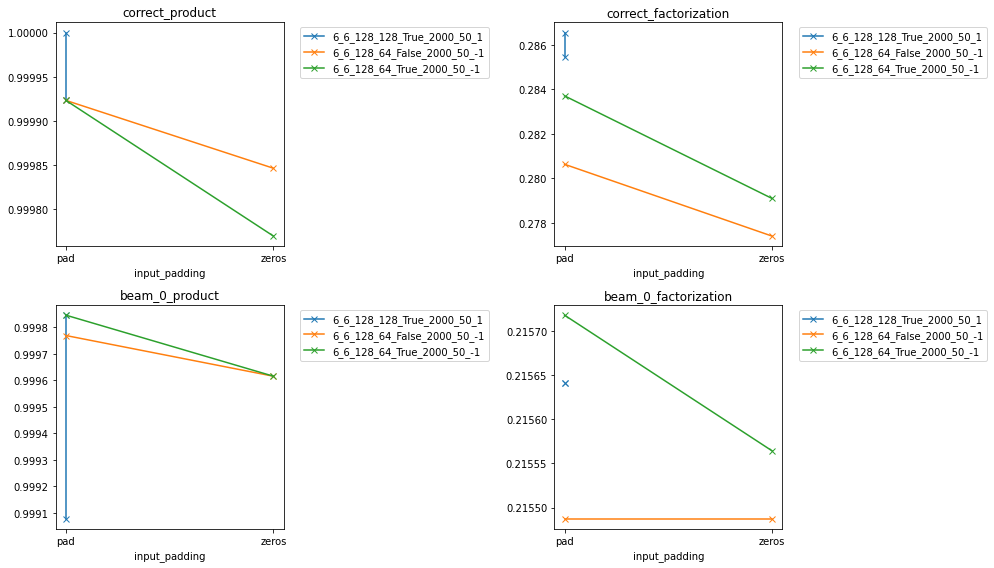

In [13]:
plot_different_values(merged, 'input_padding')

# Shared Embeddings for input/output
* Same as above. Use shared embeddings

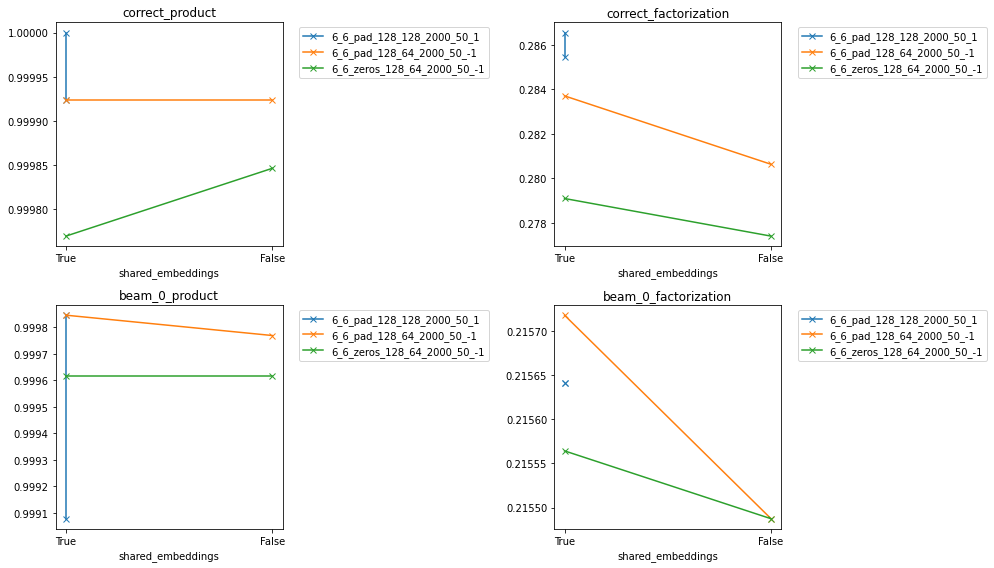

In [14]:
plot_different_values(merged, 'shared_embeddings')

## Models are a bit underfit. Using more epochs is helpful!

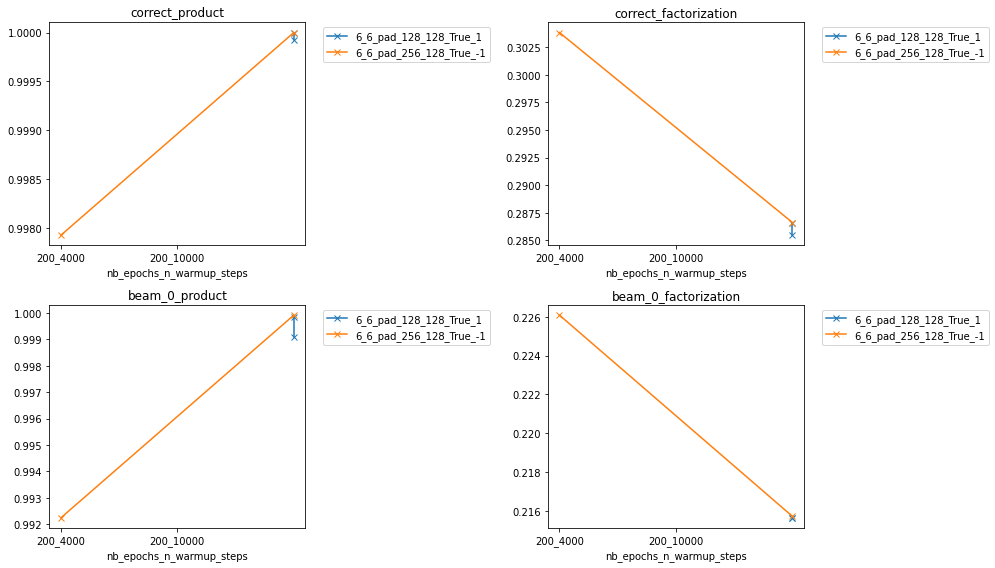

In [15]:
plot_different_values(merged, ['nb_epochs', 'n_warmup_steps'])

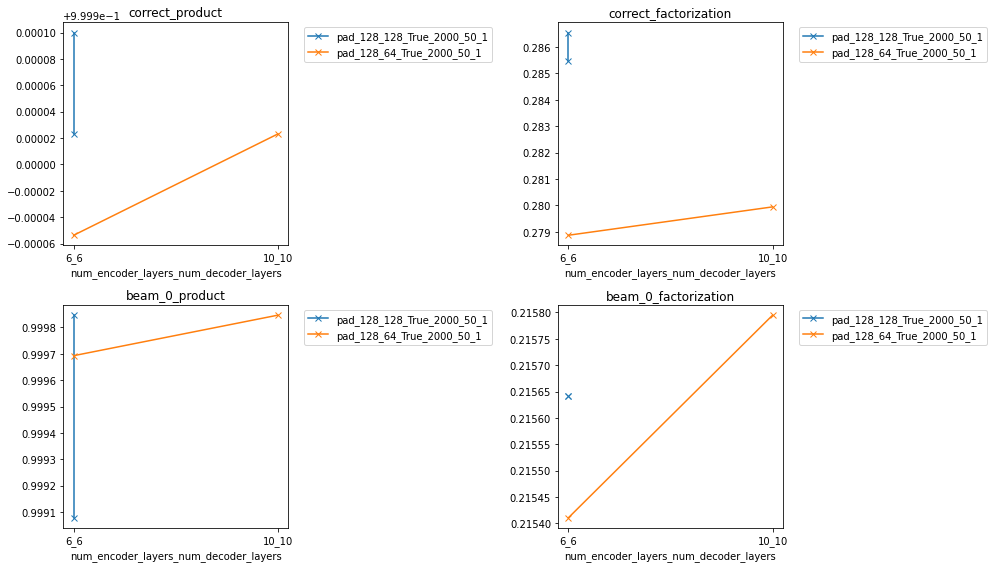

In [16]:
plot_different_values(merged, ['num_encoder_layers', 'num_decoder_layers'])

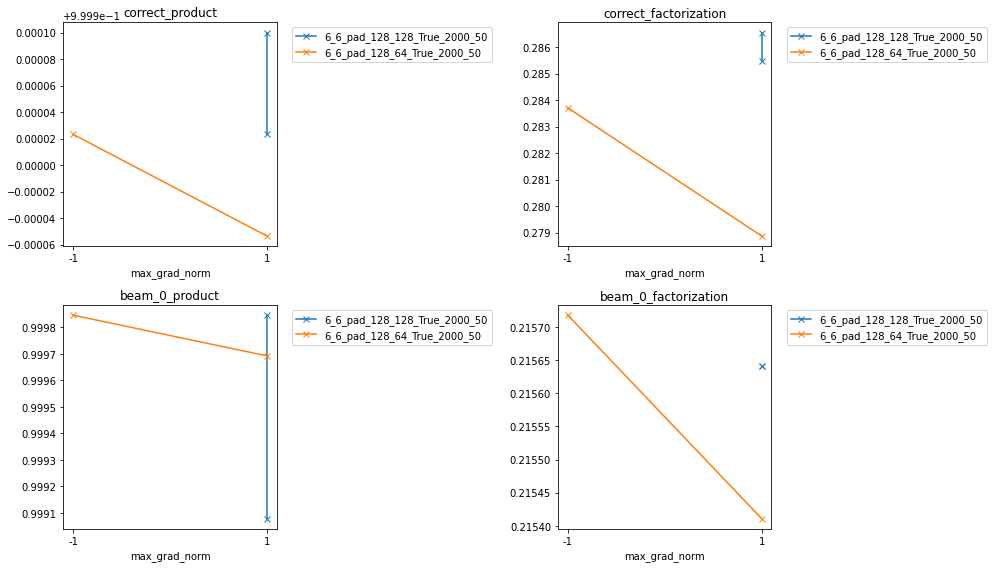

In [17]:
plot_different_values(merged, 'max_grad_norm')

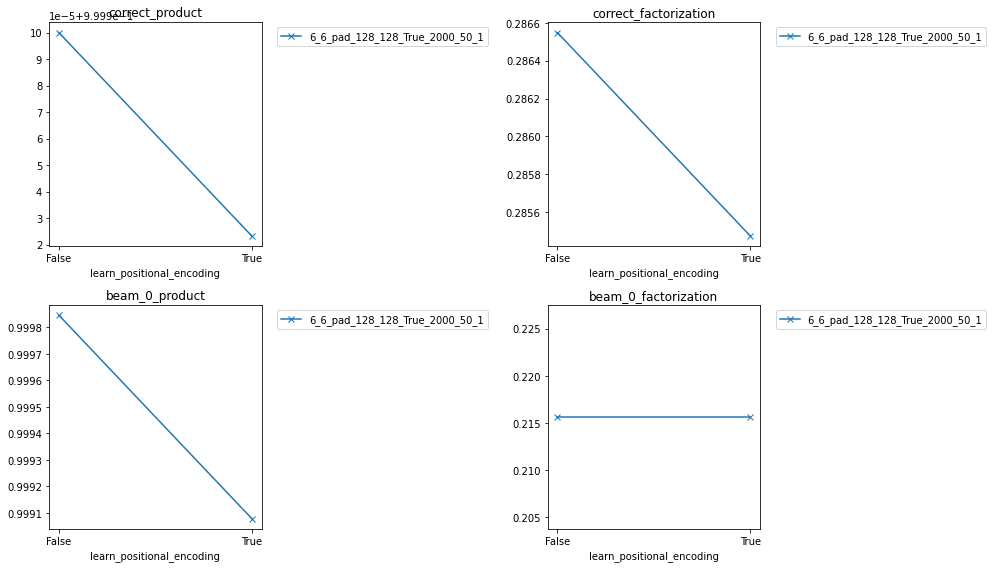

In [18]:
plot_different_values(merged, 'learn_positional_encoding')